# Nissen et al., 2023: Severe 21st-century OA in Antarctic MPAs
#
# Fig. 8 & Fig. S5: Maps of climate change effect

# how I compute the climate effect: 
# step 1: compute avg pH over top 200m in simA and simC (result: 2D fields)
# step 2: simA minus simC

# this script requires post-processed model output 

In [1]:
import sys
import os
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
from scipy.interpolate import griddata
from matplotlib import cm
from netCDF4 import Dataset, MFDataset
import pandas as pd
import copy
from scipy import interpolate
import cartopy.crs as ccrs
import cartopy
import matplotlib.pyplot as plt
import matplotlib as mpl
from cartopy.util import add_cyclic_point
import matplotlib.gridspec as gridspec
import matplotlib.ticker as mticker
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,
                                LatitudeLocator)
import matplotlib.path as mpath
from numpy.ma import masked_array

In [2]:
#------
# MODEL INFO
#------

# path to carbonate chemistry data (full model fields)
path_to_data = '/pscratch/sd/c/cnissen/carbonate_chemistry_3D_v2/' # code expects subfolders 'bottom_fields' and 'top200m_fields'

which_sim = 'ssp585' # ssp585 (Fig. 8 in paper) or ssp245 (Fig. S5 in paper)

# path to masks of MPAs and ice-shelf cavities (on regular mesh; resolution currently hard-coded to be 0.025deg) 
# -> for contours only (can be easily turned off within plotting functions)
path_to_mask = '/pscratch/sd/c/cnissen/HLRN_runs_postprocessed/masks/masks_MPAs/'

reversed_colors = True # if True: decrease in pH due to climate change in red (as in paper)
if reversed_colors:
    savepath     = '/global/cfs/cdirs/m4003/cnissen/Plots/Paper_OA_in_MPAs/Fig_maps_climate_change_effect/reversed_colors/'
else:
    savepath     = '/global/cfs/cdirs/m4003/cnissen/Plots/Paper_OA_in_MPAs/Fig_maps_climate_change_effect/'
# check existence of paths
if not os.path.exists(savepath):
    print ('Created '+savepath)
    os.makedirs(savepath)
    
#---
# load mesh info
#---

path_mesh = '/pscratch/sd/c/cnissen/'
file_mesh = 'Nissen2022_FESOM_REcoM_mesh_information_corrected_20220910.nc'

f1 = Dataset(path_mesh+file_mesh) #xr.open_dataset(path+file1)
lat_model      = f1.variables['lat'][:]
lon_model      = f1.variables['lon'][:]
zlevs    = f1.variables['zlevs'][:]
cavities = f1.variables['cavity'][:]
topo     = f1.variables['topo'][:]
area     = f1.variables['cell_area'][:]
volume   = f1.variables['cell_volume'][:]
f1.close()
print(lat_model.shape)

ind_no_cavity = np.where(cavities==0)[0]
ind_cavities = np.where(cavities==1)[0]



(72411,)


In [3]:
#----
# define lat/lon to regrid to (to plot map on reglular grid)
#----

grid_resolution_x = 0.1  #0.25 # define grid resolution of regular mesh
grid_resolution_y = 0.1 #0.0625
xi = np.arange(-180,180+grid_resolution_x,grid_resolution_x) #longitude
yi = np.arange(-90,40+grid_resolution_y,grid_resolution_y) #latitude

print ('Min/Max lon:',np.min(xi),np.max(xi))
print ('Min/Max lat:',np.min(yi),np.max(yi))
x_all,y_all = np.meshgrid(xi,yi)

print(x_all.shape)


Min/Max lon: -180.0 179.99999999997954
Min/Max lat: -90.0 39.99999999999261
(1301, 3601)


In [4]:
#----
# load bottom pH
#----

#---
# 1990s
#---
f1   = Dataset(path_to_data+'bottom_fields/'+'pH_bottom_1990s_simA.nc') 
pH_bottom_simA_1990s = f1.variables['pH_bottom'][:]
f1.close()

#---
# 2090s
#---
f1   = Dataset(path_to_data+'bottom_fields/'+'pH_bottom_2090s_simA'+which_sim+'.nc') 
pH_bottom_simA = f1.variables['pH_bottom'][:]
f1.close()
f1   = Dataset(path_to_data+'bottom_fields/'+'pH_bottom_2090s_simC'+which_sim+'.nc') 
pH_bottom_simC = f1.variables['pH_bottom'][:]
f1.close()

print(pH_bottom_simA.shape,pH_bottom_simC.shape)

pH_bottom_climate = pH_bottom_simA - pH_bottom_simC
print('Min/Max:',np.nanmin(pH_bottom_climate),np.nanmax(pH_bottom_climate))


(72411,) (72411,)
Min/Max: -0.17773294 0.13265467


In [6]:
#----
# load top200m pH
#----

#---
# 1900s
#---
f1   = Dataset(path_to_data+'top200m_fields/'+'pH_top200_1990s_simA.nc') 
pH_top200_simA_1990s = f1.variables['pH_top200'][:]
f1.close()

#---
# 2090s
#---
f1   = Dataset(path_to_data+'top200m_fields/'+'pH_top200_2090s_simA'+which_sim+'.nc') 
pH_top200_simA = f1.variables['pH_top200'][:]
f1.close()
f1   = Dataset(path_to_data+'top200m_fields/'+'pH_top200_2090s_simC'+which_sim+'.nc') 
pH_top200_simC = f1.variables['pH_top200'][:]
f1.close()
print('Min/Max:',np.nanmin(pH_top200_simA),np.nanmax(pH_top200_simA))
print('Min/Max:',np.nanmin(pH_top200_simC),np.nanmax(pH_top200_simC))

print(pH_top200_simA.shape,pH_top200_simC.shape)

pH_top200_simA_1990s = np.ma.masked_where(np.isnan(pH_top200_simA_1990s),pH_top200_simA_1990s)
pH_top200_simA = np.ma.masked_where(np.isnan(pH_top200_simA),pH_top200_simA)
pH_top200_simC = np.ma.masked_where(np.isnan(pH_top200_simC),pH_top200_simC)
pH_top200_simA[pH_top200_simA.mask==True]=0
pH_top200_simC[pH_top200_simC.mask==True]=0
pH_top200_simA_1990s[pH_top200_simA_1990s.mask==True]=0

pH_top200_climate = pH_top200_simA - pH_top200_simC
print('Min/Max:',np.nanmin(pH_top200_climate),np.nanmax(pH_top200_climate))


Min/Max: 7.531558 7.756436
Min/Max: 7.584991 7.8521557
(72411,) (72411,)
Min/Max: -0.11332893 0.027749538


In [7]:
#-------
# get subregions
#-------

#----
# get masks for MPAs (on original FEOSM mesh)
#----

f1 = Dataset(path_to_mask+'MPA_mask_AntarcticPeninsula_fesom_mesh_COARZE.nc')
mask_WAP_MPA = f1.variables['mask_fesom'][:]
f1.close()
f1 = Dataset(path_to_mask+'MPA_mask_East_Antarctica_1_fesom_mesh_COARZE.nc')
mask_eastAA1_MPA = f1.variables['mask_fesom'][:]
f1.close()
f1 = Dataset(path_to_mask+'MPA_mask_East_Antarctica_2_fesom_mesh_COARZE.nc')
mask_eastAA2_MPA = f1.variables['mask_fesom'][:]
f1.close()
f1 = Dataset(path_to_mask+'MPA_mask_East_Antarctica_3_fesom_mesh_COARZE.nc')
mask_eastAA3_MPA = f1.variables['mask_fesom'][:]
f1.close()
f1 = Dataset(path_to_mask+'MPA_mask_Orkney_fesom_mesh_COARZE.nc')
mask_Orkney_MPA = f1.variables['mask_fesom'][:]
f1.close()
f1 = Dataset(path_to_mask+'MPA_mask_RossSea_fesom_mesh_COARZE.nc')
mask_RossSea_MPA = f1.variables['mask_fesom'][:]
f1.close()
f1 = Dataset(path_to_mask+'MPA_mask_WeddellSea_fesom_mesh_COARZE.nc')
mask_WeddellSea_MPA = f1.variables['mask_fesom'][:]
f1.close()


In [8]:
#----
# get rel contribution of climate change to total change in pH
#----

# bottom
aux1 = pH_bottom_simA - pH_bottom_simA_1990s # change 2090s-1990s
aux2 = pH_bottom_simA - pH_bottom_simC # climate-change effect

# top 200m
aux3 = pH_top200_simA - pH_top200_simA_1990s # change 2090s-1990s
aux4 = pH_top200_simA - pH_top200_simC # climate-change effect

print()
print(which_sim)
print()
print('Min/max bottom:',np.min((aux2/aux1)[aux2<0]),np.max((aux2/aux1)[aux2<0]))
print('Min/max top 200m:',np.min((aux4/aux3)[aux4<0]),np.max((aux4/aux3)[aux4<0]))
print()

data_bottom = aux2/aux1
data_top200 = aux4/aux3
    
# get averages for some regions
subregions = ['RossSea_MPA_shelf','WeddellSea_MPA_shelf','AntarcticPeninsula_MPA','East_Antarctica_all_MPA_shelf',\
             'East_Antarctica_1_MPA_shelf','East_Antarctica_2_MPA_shelf','East_Antarctica_3_MPA_shelf']

for rr in range(0,len(subregions)):
    if subregions[rr] in ['RossSea_MPA']:
        ind_regions = np.where((mask_RossSea_MPA==1) & (cavities==0))[0] 
    elif subregions[rr] in ['RossSea_MPA_shelf']:
        ind_regions = np.where((mask_RossSea_MPA==1) & (cavities==0) & (topo<=2000))[0] # & (cavities==0)
    elif subregions[rr] in ['RossSea_MPA_openOcean']:
        ind_regions = np.where((mask_RossSea_MPA==1) & (cavities==0) & (topo>2000))[0]
    elif subregions[rr] in ['WeddellSea_MPA']:
        ind_regions = np.where((mask_WeddellSea_MPA==1)  & (cavities==0))[0]
    elif subregions[rr] in ['WeddellSea_MPA_shelf']:
        ind_regions = np.where((mask_WeddellSea_MPA==1) & (cavities==0) & (topo<=2000))[0]  # & (cavities==0)
    elif subregions[rr] in ['WeddellSea_MPA_openOcean']:
        ind_regions = np.where((mask_WeddellSea_MPA==1) & (cavities==0) & (topo>2000))[0]
    elif subregions[rr] in ['AntarcticPeninsula_MPA']:
        ind_regions = np.where((mask_WAP_MPA==1) & (cavities==0))[0] # & (cavities==0)
    elif subregions[rr] in ['AntarcticPeninsula_MPA_shelf']:
        ind_regions = np.where((mask_WAP_MPA==1) & (cavities==0) & (topo<=2000))[0] 
    elif subregions[rr] in ['AntarcticPeninsula_openOcean']:
        ind_regions = np.where((mask_WAP_MPA==1) & (cavities==0) & (topo>2000))[0]
    elif subregions[rr] in ['Orkney_MPA']:
        ind_regions = np.where((mask_Orkney_MPA==1) & (cavities==0))[0] 
    elif subregions[rr] in ['Orkney_MPA_shelf']:
        ind_regions = np.where((mask_Orkney_MPA==1) & (cavities==0) & (topo<=2000))[0]
    elif subregions[rr] in ['Orkney_MPA_openOcean']:
        ind_regions = np.where((mask_Orkney_MPA==1) & (cavities==0) & (topo>2000))[0]
            
    elif subregions[rr] in ['East_Antarctica_1_MPA']:
        ind_regions = np.where((mask_eastAA1_MPA==1) & (cavities==0))[0] 
    elif subregions[rr] in ['East_Antarctica_1_MPA_shelf']:
        ind_regions = np.where((mask_eastAA1_MPA==1) & (cavities==0) & (topo<=2000))[0]
    elif subregions[rr] in ['East_Antarctica_1_MPA_openOcean']:
        ind_regions = np.where((mask_eastAA1_MPA==1) & (cavities==0) & (topo>2000))[0]
    elif subregions[rr] in ['East_Antarctica_2_MPA']:
        ind_regions = np.where((mask_eastAA2_MPA==1) & (cavities==0))[0] 
    elif subregions[rr] in ['East_Antarctica_2_MPA_shelf']:
        ind_regions = np.where((mask_eastAA2_MPA==1) & (cavities==0) & (topo<=2000))[0]
    elif subregions[rr] in ['East_Antarctica_2_MPA_openOcean']:
        ind_regions = np.where((mask_eastAA2_MPA==1) & (cavities==0) & (topo>2000))[0]
    elif subregions[rr] in ['East_Antarctica_3_MPA']:
        ind_regions = np.where((mask_eastAA3_MPA==1) & (cavities==0))[0] 
    elif subregions[rr] in ['East_Antarctica_3_MPA_shelf']:
        ind_regions = np.where((mask_eastAA3_MPA==1) & (cavities==0) & (topo<=2000))[0]
    elif subregions[rr] in ['East_Antarctica_3_MPA_openOcean']:
        ind_regions = np.where((mask_eastAA3_MPA==1) & (cavities==0) & (topo>2000))[0]
            
    elif subregions[rr] in ['East_Antarctica_all_MPA']:
        ind_regions = np.where(((mask_eastAA1_MPA==1) | (mask_eastAA2_MPA==1) | (mask_eastAA3_MPA==1) ) & (cavities==0))[0] 
    elif subregions[rr] in ['East_Antarctica_all_MPA_shelf']:
        ind_regions = np.where(((mask_eastAA1_MPA==1) | (mask_eastAA2_MPA==1) | (mask_eastAA3_MPA==1) ) & (cavities==0) & (topo<=2000))[0] #
    elif subregions[rr] in ['East_Antarctica_all_MPA_openOcean']:
        ind_regions = np.where(((mask_eastAA1_MPA==1) | (mask_eastAA2_MPA==1) | (mask_eastAA3_MPA==1) ) & (cavities==0) & (topo>2000))[0]
    
    
    print(subregions[rr],'avg bottom: ',np.nansum(data_bottom[ind_regions]*area[ind_regions])/np.nansum(area[ind_regions]))
    print(subregions[rr],'avg top200m: ',np.nansum(data_top200[ind_regions]*area[ind_regions])/np.nansum(area[ind_regions]))
    print()
    


ssp585

Min/max bottom: 4.16717e-06 0.716638
Min/max top 200m: 0.00017092198 0.28595975

RossSea_MPA_shelf avg bottom:  0.18729052
RossSea_MPA_shelf avg top200m:  0.16301098

WeddellSea_MPA_shelf avg bottom:  0.19888669
WeddellSea_MPA_shelf avg top200m:  0.19455439

AntarcticPeninsula_MPA avg bottom:  0.11652604
AntarcticPeninsula_MPA avg top200m:  0.09169883

East_Antarctica_all_MPA_shelf avg bottom:  -0.1086212
East_Antarctica_all_MPA_shelf avg top200m:  0.13425711

East_Antarctica_1_MPA_shelf avg bottom:  -0.41739976
East_Antarctica_1_MPA_shelf avg top200m:  0.07623278

East_Antarctica_2_MPA_shelf avg bottom:  -0.08174501
East_Antarctica_2_MPA_shelf avg top200m:  0.110066734

East_Antarctica_3_MPA_shelf avg bottom:  0.013650529
East_Antarctica_3_MPA_shelf avg top200m:  0.17955644



In [9]:
#----
# interpolate to regular grid
#----

lat_orig,lon_orig = lat_model,lon_model 

def interpolate_fields(lat_orig,lon_orig,data,lat_final,lon_final):
    interp_method = 'cubic' # cubic, nearest, linear
    data_int = griddata((lon_orig,lat_orig),data,\
                (lon_final.ravel(), lat_final.ravel()), method=interp_method)  # Final interpolated field
    data_int = data_int.reshape((lon_final.shape[0],lon_final.shape[1])) 
    return data_int
    
#--------
print('regrid 1990s')
pH_top200_simA_1990s_int = interpolate_fields(lat_orig,lon_orig,pH_top200_simA_1990s, y_all,x_all)
pH_bottom_simA_1990s_int = interpolate_fields(lat_orig,lon_orig,pH_bottom_simA_1990s, y_all,x_all)
print('Min/Max bottom:',np.nanmin(pH_top200_simA_1990s_int),np.nanmax(pH_top200_simA_1990s_int))
print('Min/Max top200:',np.nanmin(pH_bottom_simA_1990s_int),np.nanmax(pH_bottom_simA_1990s_int))

print('regrid 2090s, simA')
pH_bottom_simA_int = interpolate_fields(lat_orig,lon_orig,pH_bottom_simA, y_all,x_all)
pH_top200_simA_int = interpolate_fields(lat_orig,lon_orig,pH_top200_simA, y_all,x_all)
print('Min/Max bottom:',np.nanmin(pH_bottom_simA_int),np.nanmax(pH_bottom_simA_int))
print('Min/Max top200:',np.nanmin(pH_top200_simA_int),np.nanmax(pH_top200_simA_int))
#pH_top200_simC_int = interpolate_fields(lat_orig,lon_orig,pH_top200_simC, y_all,x_all)

print ('regrid climate effect, top200 pH')
pH_top200_climate_int = interpolate_fields(lat_orig,lon_orig,pH_top200_climate, y_all,x_all)
print('Min/Max:',np.nanmin(pH_top200_climate_int),np.nanmax(pH_top200_climate_int))

print ('regrid climate effect, bottom pH')
pH_bottom_climate_int = interpolate_fields(lat_orig,lon_orig,pH_bottom_climate, y_all,x_all)
print('Min/Max:',np.nanmin(pH_bottom_climate_int),np.nanmax(pH_bottom_climate_int))

#---------
print ('regrid topo')
topo_int = interpolate_fields(lat_orig,lon_orig,topo,y_all,x_all)
#--------
print ('regrid cavity info')
cav_int = interpolate_fields(lat_orig,lon_orig,cavities,y_all,x_all)
#--------
print ('done')


regrid 1990s
Min/Max bottom: -343.70228566926056 75.74086223143344
Min/Max top200: -6.95705573821203 11.264489856298958
regrid 2090s, simA
Min/Max bottom: -6.9193609060780155 11.2050094630334
Min/Max top200: -328.3740857903482 72.13454318926621
regrid climate effect, top200 pH
Min/Max: -0.4342122611682573 2.574810663209032
regrid climate effect, bottom pH
Min/Max: -0.9209713983372031 0.44007712482976574
regrid topo
regrid cavity info
done


In [10]:
#----
# prepare data to plot
#----

data_plot_1990s_bottom = np.copy(pH_bottom_simA_1990s_int)
data_plot_1990s_top200 = np.copy(pH_top200_simA_1990s_int)

data_plot_2090s_bottom = np.copy(pH_bottom_simA_int)
data_plot_2090s_top200 = np.copy(pH_top200_simA_int)

data_plot1e = np.copy(pH_bottom_climate_int)
data_plot2e = np.copy(pH_top200_climate_int)

data_plot1f = data_plot_2090s_bottom-data_plot_1990s_bottom
data_plot2f = data_plot_2090s_top200-data_plot_1990s_top200

data_topo = np.copy(topo_int)
data_cav = np.copy(cav_int)

# topo & sea ice
def correct_dateline_points(data):
    # for topo & sea ice: correct a few more longitudes to get smooth contour lines across the dateline
    data[:,3] = data[:,4]
    data[:,2] = data[:,3]
    data[:,1] = data[:,2]
    data[:,0] = data[:,1]
    data[:,-4] = data[:,-5]
    data[:,-3] = data[:,-4]
    data[:,-2] = data[:,-3]
    data[:,-1] = data[:,-2]
    return data
    
data_topo = correct_dateline_points(data_topo)

data_cav[:,1] = data_cav[:,2]
data_cav[:,0] = data_cav[:,1]
data_cav[:,-2] = data_cav[:,-3]
data_cav[:,-1] = data_cav[:,-2]


data_plot_1990s_bottom, lon = add_cyclic_point(data_plot_1990s_bottom, coord=xi)
data_plot_1990s_top200, lon = add_cyclic_point(data_plot_1990s_top200, coord=xi)

data_plot_2090s_bottom, lon = add_cyclic_point(data_plot_2090s_bottom, coord=xi)
data_plot_2090s_top200, lon = add_cyclic_point(data_plot_2090s_top200, coord=xi)

data1e, lon = add_cyclic_point(data_plot1e, coord=xi)
data2e, lon = add_cyclic_point(data_plot2e, coord=xi)

data1f, lon = add_cyclic_point(data_plot1f, coord=xi)
data2f, lon = add_cyclic_point(data_plot2f, coord=xi)

data2, lonxx = add_cyclic_point(data_topo, coord=xi)
del lonxx
data3, lonxx = add_cyclic_point(data_cav, coord=xi)
del lonxx
print (data2.shape)
print (data3.shape)


#----
# correct data in cavity etc
#----

# correct topo data on land
data2[data2<0]=-999
data2[np.isnan(data2)]=-999

# cavity field
data3[data3<0]=-999
data3[np.isnan(data3)]=-999

data2[data3>=0.5]=-999
print ('done')


(1301, 3602)
(1301, 3602)
done


In [13]:
#----
# plotting function, bottom
#-----

color_cavity = 'black' #'darkgrey'

dpicnt=200
fs = 12
lw = 1.5 # topography
lw2 = 1.0 # cavity

def plot_map_circumpolar(data_plot,lon_plot,lat_plot,topo,levels1,cmap1,ctick1,\
                                    cticks_label,clabel_string,depth_label,\
                         save_plots,display_plots,savepath,filename1,path_to_mask):
    plot_colorbar = False
    fs = 10
    
    # data to plot
    data_plot1 = np.copy(data_plot)
   
    # projection
    projection=ccrs.SouthPolarStereo()
    
    plot_MPAs = True
    color_mpa = (160./255.,160./255.,160./255.) #'gold' #'white'
    lw_mpa = 2
    
    if plot_MPAs:
        which_res = '0.025'

        f1 = Dataset(path_to_mask+'MPA_mask_AntarcticPeninsula_regular_mesh_'+which_res+'deg.nc')
        mask_WAP_MPA = f1.variables['mask_mpa'][:]
        lon_MPA2 = f1.variables['lon'][:]
        lat_MPA2 = f1.variables['lat'][:]
        f1.close()
        f1 = Dataset(path_to_mask+'MPA_mask_East_Antarctica_1_regular_mesh_'+which_res+'deg.nc')
        mask_eastAA1_MPA = f1.variables['mask_mpa'][:]
        f1.close()
        f1 = Dataset(path_to_mask+'MPA_mask_East_Antarctica_2_regular_mesh_'+which_res+'deg.nc')
        mask_eastAA2_MPA = f1.variables['mask_mpa'][:]
        f1.close()
        f1 = Dataset(path_to_mask+'MPA_mask_East_Antarctica_3_regular_mesh_'+which_res+'deg.nc')
        mask_eastAA3_MPA = f1.variables['mask_mpa'][:]
        f1.close()
        f1 = Dataset(path_to_mask+'MPA_mask_Orkney_regular_mesh_'+which_res+'deg.nc')
        mask_Orkney_MPA = f1.variables['mask_mpa'][:]
        f1.close()
        f1 = Dataset(path_to_mask+'MPA_mask_RossSea_regular_mesh_'+which_res+'deg.nc')
        mask_RossSea_MPA = f1.variables['mask_mpa'][:]
        f1.close()
        f1 = Dataset(path_to_mask+'MPA_mask_WeddellSea_regular_mesh_'+which_res+'deg.nc')
        mask_WeddellSea_MPA = f1.variables['mask_mpa'][:]
        f1.close()

        f1 = Dataset(path_to_mask+'Mask_cavities_regular_mesh_'+which_res+'deg.nc')
        cav_int = f1.variables['mask_cavities'][:]
        f1.close()
        
        cav_int[cav_int.mask==True]=0

        mask_eastAA1_MPA[mask_eastAA1_MPA.mask==True]=0 #np.ma.masked_where()
        mask_eastAA2_MPA[mask_eastAA2_MPA.mask==True]=0
        mask_eastAA3_MPA[mask_eastAA3_MPA.mask==True]=0
        mask_WeddellSea_MPA[mask_WeddellSea_MPA.mask==True]=0
        mask_Orkney_MPA[mask_Orkney_MPA.mask==True]=0
        mask_RossSea_MPA[mask_RossSea_MPA.mask==True]=0
        mask_WAP_MPA[mask_WAP_MPA.mask==True]=0
        
        lon_MPA,lat_MPA = np.meshgrid(lon_MPA2,lat_MPA2)
        del lon_MPA2,lat_MPA2
            
        # correct mask so that it matches the mask used on FESOM mesh (see regrid_cavity_to_regular_mesh.ipynb)
        # for the Weddell Sea, connect piece at WAP tip with southern piece
        ind = np.where((lat_MPA<=-64.0) & (lon_MPA<-50) & (lon_MPA>-62.5)) #[0]
        # ind = np.where((lat_MPA<=-64.0) & (lon_MPA<310) & (lon_MPA>298.5)) #[0]
        mask_WeddellSea_MPA[ind]=1
        # correct piece that reaches into WAP
        ind = np.where((lat_MPA>-64.8) & (lon_MPA<-60)) #[0]
        # ind = np.where((lat_MPA >-64.8) & (lon_MPA<300)) #[0]
        mask_WeddellSea_MPA[ind]=0
            
        mask_eastAA1_MPA[cav_int==1]=0
        mask_eastAA2_MPA[cav_int==1]=0
        mask_eastAA3_MPA[cav_int==1]=0
        mask_WeddellSea_MPA[cav_int==1]=0
        mask_Orkney_MPA[cav_int==1]=0
        mask_RossSea_MPA[cav_int==1]=0
        mask_WAP_MPA[cav_int==1]=0
        
        print('min/max mask_MPA:',np.min(mask_WeddellSea_MPA),np.max(mask_WeddellSea_MPA))
        
    fig = plt.figure(figsize=(10, 9))
    ax = fig.add_subplot(1, 1, 1, projection=projection)
    ax.set_extent([-280, 80, -80, -60], crs=ccrs.PlateCarree())
    ax.add_feature(cartopy.feature.LAND,facecolor=("grey"),zorder=50)
    ax.coastlines(resolution='50m')
    # Compute a circle in axes coordinates, which we can use as a boundary
    # for the map. We can pan/zoom as much as we like - the boundary will be
    # permanently circular.
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)
    
    # plot coastal
    mm1=ax.contourf(lon_plot, lat_plot, data_plot1,\
                   levels=levels1,extend='both',cmap=cmap1,transform=ccrs.PlateCarree())
    if plot_colorbar:
        cbar = plt.colorbar(mm1,ax=ax,orientation='horizontal',fraction=0.075, pad=0.01,shrink=0.6,ticks=cticks1)
        cbar.set_label(clabel_string,fontsize=fs+5) #clabel_string
        cbar.ax.tick_params(labelsize=fs+4)
        cbar.ax.set_xticklabels(cticks_label)
        
    gl=ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True,linewidth=.5,\
                    color='grey', alpha=0.8,linestyle='--')#,xlabels_bottom=True)
    gl.top_labels = True
    gl.bottom_labels = True
    gl.left_labels = True
    gl.right_labels=True
    #gl.xlines = True
    gl.xlocator = mticker.FixedLocator([-180,-120,-60,0,60,120]) 
    gl.ylocator = mticker.FixedLocator([-70,-65])
    #gl.ylocator = LatitudeLocator()
    gl.xformatter = LongitudeFormatter()
    gl.yformatter = LatitudeFormatter()
    gl.rotate_labels = False

    lw = 2
    ax.contour(lon_plot, lat_plot, topo,levels = [2000],\
                     colors=['dimgrey','black','black'],linewidths=[lw+0.75,lw,lw],\
               linestyles=['-','-',':'],transform=ccrs.PlateCarree())
               
    #-----
    # add MPA contours
    if plot_MPAs:
        #print ('min/max lon_plot:',np.min(lon_plot),np.max(lon_plot))
        #print ('min/max lon_MPA:',np.min(lon_MPA),np.max(lon_MPA))
       
        m = np.zeros_like(mask_RossSea_MPA)
        m[:,0:8] = 1
        m[:,-8:-1] = 1
        mask_RossSea_MPA = np.ma.masked_array(mask_RossSea_MPA, m)
        
        m = np.zeros_like(mask_RossSea_MPA)
        m[0:400,:] = 1
        mask_WeddellSea_MPA = np.ma.masked_array(mask_WeddellSea_MPA, m)
        mask_WAP_MPA = np.ma.masked_array(mask_WAP_MPA, m)
        mask_RossSea_MPA = np.ma.masked_array(mask_RossSea_MPA, m)
        mask_eastAA1_MPA = np.ma.masked_array(mask_eastAA1_MPA, m)
        mask_eastAA2_MPA = np.ma.masked_array(mask_eastAA2_MPA, m)
        mask_eastAA3_MPA = np.ma.masked_array(mask_eastAA3_MPA, m)
        mask_Orkney_MPA  = np.ma.masked_array(mask_Orkney_MPA, m)
        
        ax.contour(lon_MPA, lat_MPA, mask_WeddellSea_MPA,levels = [0.5],\
                         colors=[color_mpa],linewidths=[lw_mpa],linestyles=['-'],transform=ccrs.PlateCarree())
        ax.contour(lon_MPA, lat_MPA, mask_WAP_MPA,levels = [lw_mpa],\
                         colors=[color_mpa],linewidths=[lw_mpa],linestyles=['-'],transform=ccrs.PlateCarree())
        ax.contour(lon_MPA, lat_MPA, mask_RossSea_MPA,levels = [0.5],\
                         colors=[color_mpa],linewidths=[lw_mpa],linestyles=['-'],transform=ccrs.PlateCarree())
        ax.contour(lon_MPA, lat_MPA, mask_eastAA1_MPA,levels = [0.5],\
                         colors=[color_mpa],linewidths=[lw_mpa],linestyles=['-'],transform=ccrs.PlateCarree())
        ax.contour(lon_MPA, lat_MPA, mask_eastAA2_MPA,levels = [0.5],\
                         colors=[color_mpa],linewidths=[lw_mpa],linestyles=['-'],transform=ccrs.PlateCarree())
        ax.contour(lon_MPA, lat_MPA, mask_eastAA3_MPA,levels = [0.5],\
                         colors=[color_mpa],linewidths=[lw_mpa],linestyles=['-'],transform=ccrs.PlateCarree())
        ax.contour(lon_MPA, lat_MPA, mask_Orkney_MPA,levels = [0.5],\
                         colors=[color_mpa],linewidths=[lw_mpa],linestyles=['-'],transform=ccrs.PlateCarree())
        
    ## cavities
    #ax.contour(lon_MPA, lat_MPA, cav_int,levels = [0.5],\
    #                     colors=['gainsboro'],linewidths=[lw],linestyles=['-'],transform=ccrs.PlateCarree())
    # cavities
    ind_2 = np.where(lat_plot[:,0]>-75.0)[0]
    cav_int[0:400,:] = 1 # high-high-latitudes
    ind_s = 420
    cav_int[ind_s:,-5] =  -999
    cav_int[ind_s:,-4] =  -999
    cav_int[ind_s:,-3] =  -999
    cav_int[ind_s:,-2] =  -999
    cav_int[ind_s:,-1] =  -999
    cav_int[ind_s:,0]  =  -999
    cav_int[ind_s:,1]  =  -999
    cav_int[ind_s:,2]  =  -999
    cav_int[ind_s:,3]  =  -999
    cav_int[ind_s:,4]  =  -999
    
    m = np.zeros_like(cav_int)
    m[:,0:10] = 1
    m[:,-10:-1] = 1
    cav_int = np.ma.masked_array(cav_int, m)

    cav_color = (50./255.,50./255.,50./255.)
    ax.contour(lon_MPA, lat_MPA, cav_int,levels = [0.5],\
                         colors=[cav_color],\
               linewidths=[lw],linestyles=['-'],transform=ccrs.PlateCarree())
    
    dpicnt = 200

    save_plots = True
    if save_plots:
        if plot_colorbar:
            filename = filename1+'.png'
        else:
            filename = filename1+'_no_colorbar.png'
        plt.savefig(savepath+filename,dpi = dpicnt, bbox_inches='tight')
        del filename
    if display_plots:
        plt.show()
    else:
        plt.close(fig)
        
    #return lon_MPA, lat_MPA,cav_int
        

Map_change_bottom_pH_2090s_minus_1990sssp585
min/max mask_MPA: 0.0 1.0


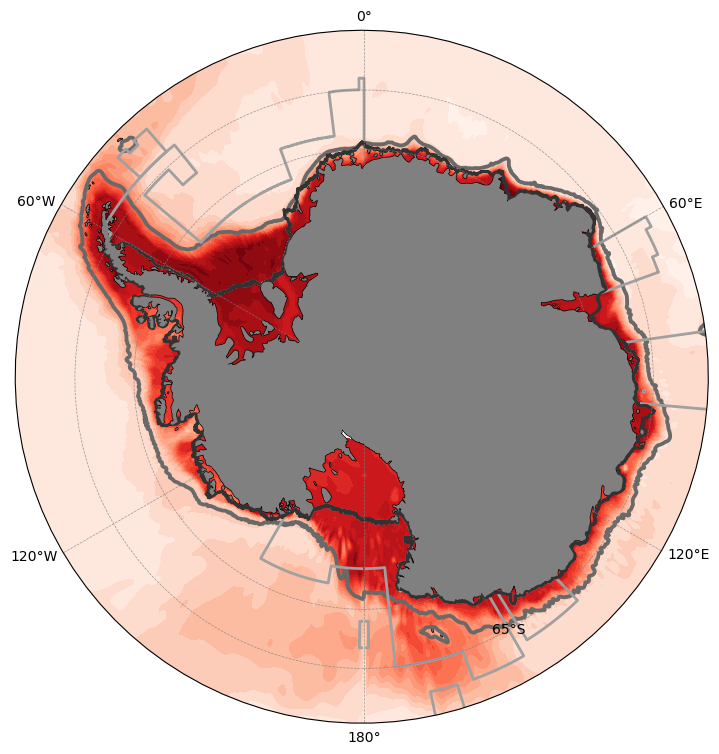

In [14]:
#----
# plot: change in pH, bottom, 2090s-1990s
#----

lon_plot,lat_plot = np.meshgrid(lon,yi) 

save_plots = False
display_plots = True

if reversed_colors:
    cmap1 = copy.copy(plt.cm.Reds_r)
else:
    cmap1 = copy.copy(plt.cm.Blues_r)
#cmap1.set_under('white')

data_plot = np.copy(data1f) #data_plot_2090s_bottom-data_plot_1990s_bottom)
#data_plot[data_plot<=0]=0
data_plot = np.ma.masked_where(np.isnan(data_plot),data_plot)
#data_plot[data_plot<0]=0 #-999

data_plot[:,-1] = data_plot[:,1]
data_plot[:,-2] = data_plot[:,1]
data_plot[:,-3] = data_plot[:,1]
data_plot[:,-4] = data_plot[:,1]

clabel_string = 'XX'
depth_label = 'XX'
filename = 'Map_change_bottom_pH_2090s_minus_1990s'+which_sim      
print(filename)

levels1a = np.arange(-0.45,0+0.025,0.025) 
cticks1 = [-0.4,-0.3,-0.2,-0.1,0]
cticks_label = [-0.4,-0.3,-0.2,-0.1,0]

plot_map_circumpolar(data_plot,lon_plot,lat_plot,data2,\
                     levels1a,cmap1,cticks1,cticks_label,clabel_string,depth_label,\
                                save_plots,display_plots,savepath,filename,path_to_mask)


min/max mask_MPA: 0.0 1.0


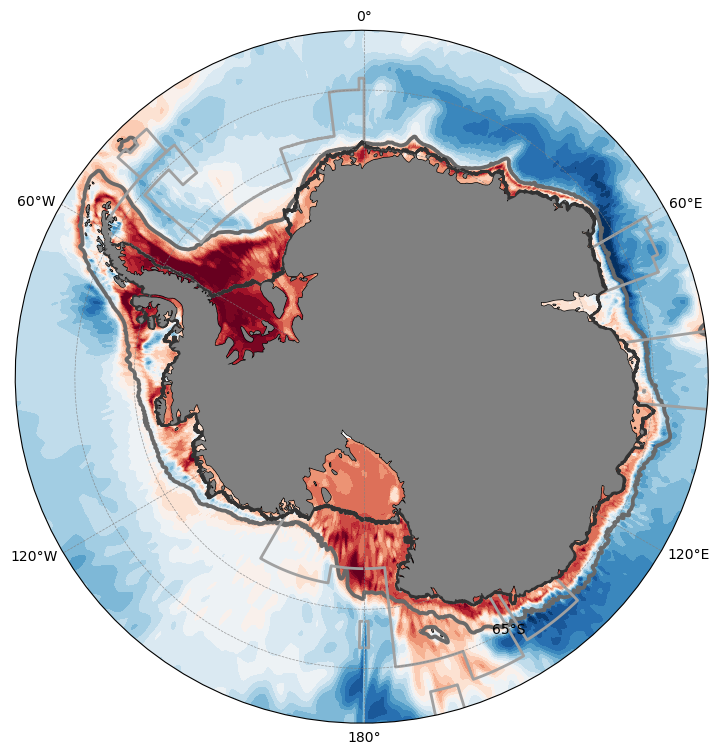

In [15]:
#----
# plot: climate-change effect, pH, bottom, 2090s
#----

lon_plot,lat_plot = np.meshgrid(lon,yi) 

save_plots = False
display_plots = True

if reversed_colors:
    cmap1 = copy.copy(plt.cm.RdBu)
else:
    cmap1 = copy.copy(plt.cm.RdBu_r) 
#cmap1.set_under('white')

data_plot = np.copy(data1e)
data_plot = np.ma.masked_where(np.isnan(data_plot),data_plot)

data_plot[:,-1] = data_plot[:,1]
data_plot[:,-2] = data_plot[:,1]
data_plot[:,-3] = data_plot[:,1]
data_plot[:,-4] = data_plot[:,1]

clabel_string = 'XX'
depth_label = 'XX'
filename = 'Map_climate_change_effect_bottom_pH_2090s_'+which_sim      

levels1a = np.arange(-0.1,0.1+0.01,0.01) #np.arange(-100,100+10,10) #np.arange(-0.1,0.1+0.01,0.01)
cticks1 = [-0.1,-0.05,0,0.05,0.1]
cticks_label = [-0.1,-0.05,0,0.05,0.1]

plot_map_circumpolar(data_plot,lon_plot,lat_plot,data2,\
                     levels1a,cmap1,cticks1,cticks_label,clabel_string,depth_label,\
                                save_plots,display_plots,savepath,filename,path_to_mask)


In [19]:
#----
# plotting function, top 200m
#-----

color_cavity = 'black' #'darkgrey'

dpicnt=200
fs = 12
lw = 1.5 # topography
lw2 = 1.0 # cavity

def plot_map_circumpolar_fill_cavity(data_plot,lon_plot,lat_plot,topo,levels1,cmap1,ctick1,\
                                    cticks_label,clabel_string,depth_label,\
                         save_plots,display_plots,savepath,filename1,path_to_mask):
    plot_colorbar = False
    fs = 10
    
    data_plot1 = np.copy(data_plot)
        
    # projection
    projection=ccrs.SouthPolarStereo()
    
    plot_MPAs = True
    color_mpa = (160./255.,160./255.,160./255.) #'gold' #'white'
    lw_mpa = 2
    
    if plot_MPAs:
        which_res = '0.025'

        f1 = Dataset(path_to_mask+'MPA_mask_AntarcticPeninsula_regular_mesh_'+which_res+'deg.nc')
        mask_WAP_MPA = f1.variables['mask_mpa'][:]
        lon_MPA2 = f1.variables['lon'][:]
        lat_MPA2 = f1.variables['lat'][:]
        f1.close()
        f1 = Dataset(path_to_mask+'MPA_mask_East_Antarctica_1_regular_mesh_'+which_res+'deg.nc')
        mask_eastAA1_MPA = f1.variables['mask_mpa'][:]
        f1.close()
        f1 = Dataset(path_to_mask+'MPA_mask_East_Antarctica_2_regular_mesh_'+which_res+'deg.nc')
        mask_eastAA2_MPA = f1.variables['mask_mpa'][:]
        f1.close()
        f1 = Dataset(path_to_mask+'MPA_mask_East_Antarctica_3_regular_mesh_'+which_res+'deg.nc')
        mask_eastAA3_MPA = f1.variables['mask_mpa'][:]
        f1.close()
        f1 = Dataset(path_to_mask+'MPA_mask_Orkney_regular_mesh_'+which_res+'deg.nc')
        mask_Orkney_MPA = f1.variables['mask_mpa'][:]
        f1.close()
        f1 = Dataset(path_to_mask+'MPA_mask_RossSea_regular_mesh_'+which_res+'deg.nc')
        mask_RossSea_MPA = f1.variables['mask_mpa'][:]
        f1.close()
        f1 = Dataset(path_to_mask+'MPA_mask_WeddellSea_regular_mesh_'+which_res+'deg.nc')
        mask_WeddellSea_MPA = f1.variables['mask_mpa'][:]
        f1.close()

        f1 = Dataset(path_to_mask+'Mask_cavities_regular_mesh_'+which_res+'deg.nc')
        cav_int = f1.variables['mask_cavities'][:]
        f1.close()
        
        cav_int[cav_int.mask==True]=0

        mask_eastAA1_MPA[mask_eastAA1_MPA.mask==True]=0 #np.ma.masked_where()
        mask_eastAA2_MPA[mask_eastAA2_MPA.mask==True]=0
        mask_eastAA3_MPA[mask_eastAA3_MPA.mask==True]=0
        mask_WeddellSea_MPA[mask_WeddellSea_MPA.mask==True]=0
        mask_Orkney_MPA[mask_Orkney_MPA.mask==True]=0
        mask_RossSea_MPA[mask_RossSea_MPA.mask==True]=0
        mask_WAP_MPA[mask_WAP_MPA.mask==True]=0
        
        lon_MPA,lat_MPA = np.meshgrid(lon_MPA2,lat_MPA2)
        del lon_MPA2,lat_MPA2
            
        # correct mask so that it matches the mask used on FESOM mesh (see regrid_cavity_to_regular_mesh.ipynb)
        # for the Weddell Sea, connect piece at WAP tip with southern piece
        ind = np.where((lat_MPA<=-64.0) & (lon_MPA<-50) & (lon_MPA>-62.5)) #[0]
        # ind = np.where((lat_MPA<=-64.0) & (lon_MPA<310) & (lon_MPA>298.5)) #[0]
        mask_WeddellSea_MPA[ind]=1
        # correct piece that reaches into WAP
        ind = np.where((lat_MPA>-64.8) & (lon_MPA<-60)) #[0]
        # ind = np.where((lat_MPA >-64.8) & (lon_MPA<300)) #[0]
        mask_WeddellSea_MPA[ind]=0
            
        mask_eastAA1_MPA[cav_int==1]=0
        mask_eastAA2_MPA[cav_int==1]=0
        mask_eastAA3_MPA[cav_int==1]=0
        mask_WeddellSea_MPA[cav_int==1]=0
        mask_Orkney_MPA[cav_int==1]=0
        mask_RossSea_MPA[cav_int==1]=0
        mask_WAP_MPA[cav_int==1]=0
        
        print('min/max mask_MPA:',np.min(mask_WeddellSea_MPA),np.max(mask_WeddellSea_MPA))
        
        
        
    fig = plt.figure(figsize=(10, 9))
    ax = fig.add_subplot(1, 1, 1, projection=projection)
    ax.set_extent([-280, 80, -80, -60], crs=ccrs.PlateCarree())
    ax.add_feature(cartopy.feature.LAND,facecolor=("grey"),zorder=50)
    ax.coastlines(resolution='50m')
    # Compute a circle in axes coordinates, which we can use as a boundary
    # for the map. We can pan/zoom as much as we like - the boundary will be
    # permanently circular.
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)
    
    # plot coastal
    mm1=ax.contourf(lon_plot, lat_plot, data_plot1,\
                   levels=levels1,extend='both',cmap=cmap1,transform=ccrs.PlateCarree())
    if plot_colorbar:
        cbar = plt.colorbar(mm1,ax=ax,orientation='horizontal',fraction=0.075, pad=0.01,shrink=0.6,ticks=cticks1)
        cbar.set_label(clabel_string,fontsize=fs+5) #clabel_string
        cbar.ax.tick_params(labelsize=fs+4)
        cbar.ax.set_xticklabels(cticks_label)
        
    gl=ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True,linewidth=.5,\
                    color='grey', alpha=0.8,linestyle='--')#,xlabels_bottom=True)
    gl.top_labels = True
    gl.bottom_labels = True
    gl.left_labels = True
    gl.right_labels=True
    #gl.xlines = True
    gl.xlocator = mticker.FixedLocator([-180,-120,-60,0,60,120]) 
    gl.ylocator = mticker.FixedLocator([-70,-65])
    #gl.ylocator = LatitudeLocator()
    gl.xformatter = LongitudeFormatter()
    gl.yformatter = LatitudeFormatter()
    gl.rotate_labels = False

    lw = 2
    ax.contour(lon_plot, lat_plot, topo,levels = [2000],\
                     colors=['dimgrey','black','black'],linewidths=[lw+0.75,lw,lw],\
               linestyles=['-','-',':'],transform=ccrs.PlateCarree())
               
    #-----
    # add MPA contours
    if plot_MPAs:
        #print ('min/max lon_plot:',np.min(lon_plot),np.max(lon_plot))
        #print ('min/max lon_MPA:',np.min(lon_MPA),np.max(lon_MPA))
       
        m = np.zeros_like(mask_RossSea_MPA)
        m[:,0:8] = 1
        m[:,-8:-1] = 1
        mask_RossSea_MPA = np.ma.masked_array(mask_RossSea_MPA, m)
        
        m = np.zeros_like(mask_RossSea_MPA)
        m[0:400,:] = 1
        mask_WeddellSea_MPA = np.ma.masked_array(mask_WeddellSea_MPA, m)
        mask_WAP_MPA = np.ma.masked_array(mask_WAP_MPA, m)
        mask_RossSea_MPA = np.ma.masked_array(mask_RossSea_MPA, m)
        mask_eastAA1_MPA = np.ma.masked_array(mask_eastAA1_MPA, m)
        mask_eastAA2_MPA = np.ma.masked_array(mask_eastAA2_MPA, m)
        mask_eastAA3_MPA = np.ma.masked_array(mask_eastAA3_MPA, m)
        mask_Orkney_MPA  = np.ma.masked_array(mask_Orkney_MPA, m)
        
        ax.contour(lon_MPA, lat_MPA, mask_WeddellSea_MPA,levels = [0.5],\
                         colors=[color_mpa],linewidths=[lw_mpa],linestyles=['-'],transform=ccrs.PlateCarree())
        ax.contour(lon_MPA, lat_MPA, mask_WAP_MPA,levels = [lw_mpa],\
                         colors=[color_mpa],linewidths=[lw_mpa],linestyles=['-'],transform=ccrs.PlateCarree())
        ax.contour(lon_MPA, lat_MPA, mask_RossSea_MPA,levels = [0.5],\
                         colors=[color_mpa],linewidths=[lw_mpa],linestyles=['-'],transform=ccrs.PlateCarree())
        ax.contour(lon_MPA, lat_MPA, mask_eastAA1_MPA,levels = [0.5],\
                         colors=[color_mpa],linewidths=[lw_mpa],linestyles=['-'],transform=ccrs.PlateCarree())
        ax.contour(lon_MPA, lat_MPA, mask_eastAA2_MPA,levels = [0.5],\
                         colors=[color_mpa],linewidths=[lw_mpa],linestyles=['-'],transform=ccrs.PlateCarree())
        ax.contour(lon_MPA, lat_MPA, mask_eastAA3_MPA,levels = [0.5],\
                         colors=[color_mpa],linewidths=[lw_mpa],linestyles=['-'],transform=ccrs.PlateCarree())
        ax.contour(lon_MPA, lat_MPA, mask_Orkney_MPA,levels = [0.5],\
                         colors=[color_mpa],linewidths=[lw_mpa],linestyles=['-'],transform=ccrs.PlateCarree())
        
    ## cavities
    #ax.contour(lon_MPA, lat_MPA, cav_int,levels = [0.5],\
    #                     colors=['gainsboro'],linewidths=[lw],linestyles=['-'],transform=ccrs.PlateCarree())
    # cavities
    ind_2 = np.where(lat_plot[:,0]>-75.0)[0]
    cav_int[0:400,:] = 1 # high-high-latitudes
    ind_s = 420
    cav_int[ind_s:,-5] =  -999
    cav_int[ind_s:,-4] =  -999
    cav_int[ind_s:,-3] =  -999
    cav_int[ind_s:,-2] =  -999
    cav_int[ind_s:,-1] =  -999
    cav_int[ind_s:,0]  =  -999
    cav_int[ind_s:,1]  =  -999
    cav_int[ind_s:,2]  =  -999
    cav_int[ind_s:,3]  =  -999
    cav_int[ind_s:,4]  =  -999
    
    m = np.zeros_like(cav_int)
    m[:,0:10] = 1
    m[:,-10:-1] = 1
    cav_int = np.ma.masked_array(cav_int, m)

    cav_color = (50./255.,50./255.,50./255.)
    cav_color2 = 'oldlace' #(218./255.,228./255.,238./255.)
    
    ax.contourf(lon_MPA, lat_MPA, cav_int,levels = [0.5,1],\
                         colors=[cav_color2],\
               linewidths=[lw],linestyles=['-'],transform=ccrs.PlateCarree())
    
    ax.contour(lon_MPA, lat_MPA, cav_int,levels = [0.5],\
                         colors=[cav_color],\
               linewidths=[lw],linestyles=['-'],transform=ccrs.PlateCarree())
    
    dpicnt = 200

    save_plots = True
    if save_plots:
        if plot_colorbar:
            filename = filename1+'.png'
        else:
            filename = filename1+'_no_colorbar.png'
        plt.savefig(savepath+filename,dpi = dpicnt, bbox_inches='tight')
        del filename
    if display_plots:
        plt.show()
    else:
        plt.close(fig)
        
    #return lon_MPA, lat_MPA,cav_int
        

Map_change_top200m_pH_2090s_minus_1990sssp585
min/max mask_MPA: 0.0 1.0


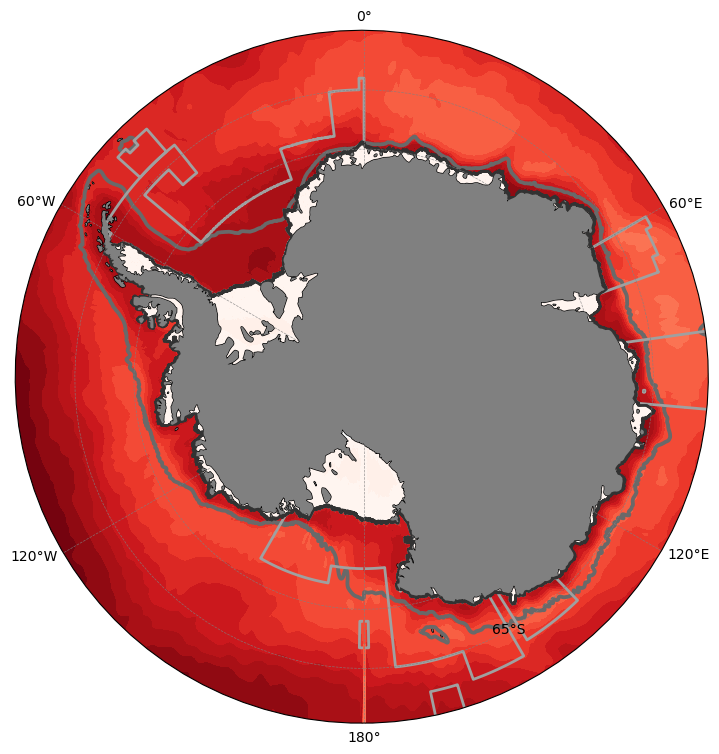

In [17]:
#----
# plot: change in pH, top200m, 2090s-1990s
#----

lon_plot,lat_plot = np.meshgrid(lon,yi) 

save_plots = False
display_plots = True

if reversed_colors:
    cmap1 = copy.copy(plt.cm.Reds_r)
else:
    cmap1 = copy.copy(plt.cm.Blues_r)
#cmap1.set_under('white')

data_plot = np.copy(data2f)
#data_plot[data_plot<=0]=0
data_plot = np.ma.masked_where(np.isnan(data_plot),data_plot)
#data_plot[data_plot<0]=0 #-999

data_plot[:,-1] = data_plot[:,1]
data_plot[:,-2] = data_plot[:,1]
data_plot[:,-3] = data_plot[:,1]
data_plot[:,-4] = data_plot[:,1]

clabel_string = 'XX'
depth_label = 'XX'
filename = 'Map_change_top200m_pH_2090s_minus_1990s'+which_sim      
print(filename)

levels1a = np.arange(-0.45,0+0.025,0.025) #np.arange(-100,100+10,10) #np.arange(-0.1,0.1+0.01,0.01)
cticks1 = [-0.4,-0.3,-0.2,-0.1,0]
cticks_label = [-0.4,-0.3,-0.2,-0.1,0]

plot_map_circumpolar(data_plot,lon_plot,lat_plot,data2,\
                     levels1a,cmap1,cticks1,cticks_label,clabel_string,depth_label,\
                                save_plots,display_plots,savepath,filename,path_to_mask)



min/max mask_MPA: 0.0 1.0


/global/common/software/nersc/pe/conda-envs/23.10.0/python-3.11/nersc-python/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:1655: UserWarning: linewidths is ignored by contourf
  result = super().contourf(*args, **kwargs)


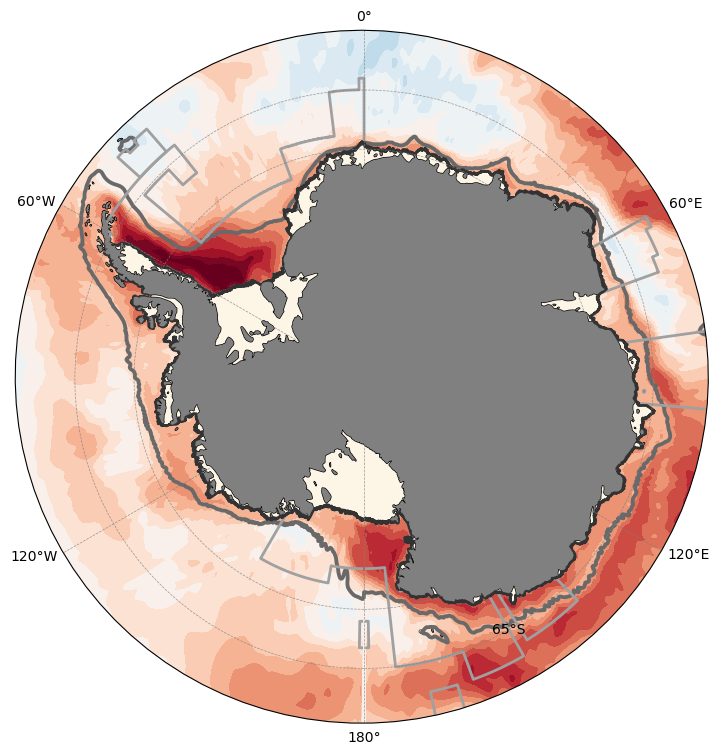

In [20]:
#----
# plot: climate-change effect, pH, top 200m, 2090s
#----

lon_plot,lat_plot = np.meshgrid(lon,yi) 

save_plots = False
display_plots = True

if reversed_colors:
    cmap1 = copy.copy(plt.cm.RdBu)
else:
    cmap1 = copy.copy(plt.cm.RdBu_r) 
#cmap1.set_under('white')

data_plot = np.copy(data2e)
data_plot = np.ma.masked_where(np.isnan(data_plot),data_plot)

data_plot[:,-1] = data_plot[:,1]
data_plot[:,-2] = data_plot[:,1]
data_plot[:,-3] = data_plot[:,1]
data_plot[:,-4] = data_plot[:,1]

clabel_string = 'XX'
depth_label = 'XX'
filename = 'Map_climate_change_effect_top200m_pH_2090s_'+which_sim

levels1a = np.arange(-0.1,0.1+0.01,0.01) #np.arange(-100,100+10,10) #np.arange(-0.1,0.1+0.01,0.01)
cticks1 = [-0.1,-0.05,0,0.05,0.1]
cticks_label = [-0.1,-0.05,0,0.05,0.1]

plot_map_circumpolar_fill_cavity(data_plot,lon_plot,lat_plot,data2,\
                     levels1a,cmap1,cticks1,cticks_label,clabel_string,depth_label,\
                                save_plots,display_plots,savepath,filename,path_to_mask)


In [21]:
#----
# COLORBAR only
#-----

color_cavity = 'black' #'darkgrey'

dpicnt=200
fs = 12
lw = 1.5 # topography
lw2 = 1.0 # cavity

def plot_map_circumpolar_colorbar_only(data_plot,lon_plot,lat_plot,topo,levels1,cmap1,ctick1,\
                                    cticks_label,clabel_string,depth_label,\
                         save_plots,display_plots,savepath,filename1):
    fs = 10

    # data to plot
    data_plot1 = np.copy(data_plot)
        
    # projection
    projection=ccrs.SouthPolarStereo()
    
    fig = plt.figure(figsize=(10, 9))
    ax = fig.add_subplot(1, 1, 1, projection=projection)
    ax.set_extent([-280, 80, -80, -60], crs=ccrs.PlateCarree())
    ax.add_feature(cartopy.feature.LAND,facecolor=("grey"),zorder=50)
    ax.coastlines(resolution='50m')
    # Compute a circle in axes coordinates, which we can use as a boundary
    # for the map. We can pan/zoom as much as we like - the boundary will be
    # permanently circular.
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)
    
    # plot coastal
    mm1=ax.contourf(lon_plot, lat_plot, data_plot1,\
                   levels=levels1,extend='both',cmap=cmap1,transform=ccrs.PlateCarree())
    plt.gca().set_visible(False)
    cbar = plt.colorbar(mm1,ax=ax,orientation='horizontal',fraction=0.075, pad=0.01,shrink=0.6,ticks=cticks1)
    cbar.set_label(clabel_string,fontsize=fs+5) #clabel_string
    cbar.ax.tick_params(labelsize=fs+4)
    cbar.ax.set_xticklabels(cticks_label)
        
    dpicnt = 200

    save_plots = True
    if save_plots:
        filename = filename1+'_COLORBAR_ONLY.png'
        plt.savefig(savepath+filename,dpi = dpicnt, bbox_inches='tight')
        del filename
    if display_plots:
        plt.show()
    else:
        plt.close(fig)
        
    #---
    # eps
    #---
    plot_eps = True
    if plot_eps:
        print('eps...')

        fig = plt.figure(figsize=(10, 9))
        ax = fig.add_subplot(1, 1, 1, projection=projection)
        ax.set_extent([-280, 80, -80, -60], crs=ccrs.PlateCarree())
        ax.add_feature(cartopy.feature.LAND,facecolor=("grey"),zorder=50)
        ax.coastlines(resolution='50m')
        # Compute a circle in axes coordinates, which we can use as a boundary
        # for the map. We can pan/zoom as much as we like - the boundary will be
        # permanently circular.
        theta = np.linspace(0, 2*np.pi, 100)
        center, radius = [0.5, 0.5], 0.5
        verts = np.vstack([np.sin(theta), np.cos(theta)]).T
        circle = mpath.Path(verts * radius + center)
        ax.set_boundary(circle, transform=ax.transAxes)

        # plot coastal
        mm1=ax.contourf(lon_plot, lat_plot, data_plot1,\
                       levels=levels1,extend='both',cmap=cmap1,transform=ccrs.PlateCarree())
        plt.gca().set_visible(False)
        cbar = plt.colorbar(mm1,ax=ax,orientation='horizontal',fraction=0.075, pad=0.01,shrink=0.6,ticks=cticks1)
        cbar.ax.tick_params(labelsize=fs+4)
        cbar.ax.set_xticklabels(['']*len(cticks1))
        #cbar.ax.set_xticklabels(cticks_label)

        dpicnt = 200

        save_plots = True
        if save_plots:
            filename = filename1+'_COLORBAR_ONLY.eps'
            plt.savefig(savepath+filename,dpi = dpicnt, bbox_inches='tight',format='eps')
            del filename
        if display_plots:
            plt.show()
        else:
            plt.close(fig)
            
        
    #return lon_MPA, lat_MPA,cav_int
        

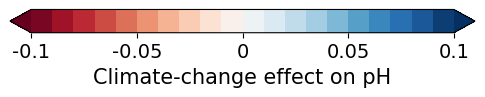

eps...


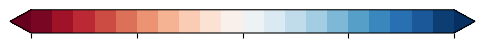

In [22]:
#----
# plot: pH, bottom, 2090s
#----

lon_plot,lat_plot = np.meshgrid(lon,yi) 

save_plots = False
display_plots = True

if reversed_colors:
    cmap1 = copy.copy(plt.cm.RdBu)
else:
    cmap1 = copy.copy(plt.cm.RdBu_r) 
#cmap1.set_under('white')

data_plot = np.copy(data2e)
#data_plot[data_plot<=0]=0
data_plot = np.ma.masked_where(np.isnan(data_plot),data_plot)
#data_plot[data_plot<0]=0 #-999

data_plot[:,-1] = data_plot[:,1]
data_plot[:,-2] = data_plot[:,1]
data_plot[:,-3] = data_plot[:,1]
data_plot[:,-4] = data_plot[:,1]

clabel_string = 'Climate-change effect on pH'
depth_label = 'XX'
filename = 'Map_climate_change_effect_pH_2090s'      

levels1a = np.arange(-0.1,0.1+0.01,0.01) #np.arange(-100,100+10,10) #np.arange(-0.1,0.1+0.01,0.01)
cticks1 = [-0.1,-0.05,0,0.05,0.1]
cticks_label = [-0.1,-0.05,0,0.05,0.1]

plot_colorbar = True
if plot_colorbar:
    plot_map_circumpolar_colorbar_only(data_plot,lon_plot,lat_plot,data2,\
                     levels1a,cmap1,cticks1,cticks_label,clabel_string,depth_label,\
                                save_plots,display_plots,savepath,filename)


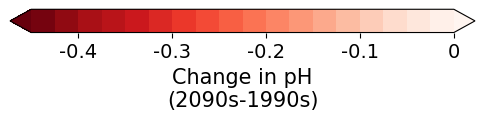

eps...


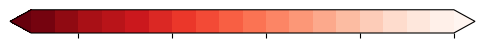

In [23]:
#----
# plot: change in pH, bottom, 2090s-1990s
#----

lon_plot,lat_plot = np.meshgrid(lon,yi) 

save_plots = False
display_plots = True

if reversed_colors:
    cmap1 = copy.copy(plt.cm.Reds_r)
else:
    cmap1 = copy.copy(plt.cm.Blues_r)

data_plot = np.copy(data2f)
#data_plot[data_plot<=0]=0
data_plot = np.ma.masked_where(np.isnan(data_plot),data_plot)
#data_plot[data_plot<0]=0 #-999

data_plot[:,-1] = data_plot[:,1]
data_plot[:,-2] = data_plot[:,1]
data_plot[:,-3] = data_plot[:,1]
data_plot[:,-4] = data_plot[:,1]

clabel_string = 'Change in pH\n(2090s-1990s)'
depth_label = 'XX'
filename = 'Map_change_top200m_pH_2090s_minus_1990s'      

levels1a = np.arange(-0.45,0+0.025,0.025) #np.arange(-100,100+10,10) #np.arange(-0.1,0.1+0.01,0.01)
cticks1 = [-0.4,-0.3,-0.2,-0.1,0]
cticks_label = [-0.4,-0.3,-0.2,-0.1,0]

plot_colorbar = True
if plot_colorbar:
    plot_map_circumpolar_colorbar_only(data_plot,lon_plot,lat_plot,data2,\
                     levels1a,cmap1,cticks1,cticks_label,clabel_string,depth_label,\
                                save_plots,display_plots,savepath,filename)


In [24]:
print(savepath)

/global/cfs/cdirs/m4003/cnissen/Plots/Paper_OA_in_MPAs/Fig_maps_climate_change_effect/reversed_colors/
